# 1. Understanding the ACE Intelligence Pipeline

## A Step-by-Step Walkthrough

This notebook breaks down the ACE Intelligence System pipeline to help you understand exactly how data flows through each transformation step. We'll use small data samples (10 rows) to see what's happening at each stage.

### What We're Analyzing
The ACE (Automated Camera Enforcement) system tracks bus violations and measures their impact on bus speeds. The "paradox" we're investigating is whether increased enforcement actually leads to better bus performance.

### Key Questions We'll Answer
- How do we calculate the **paradox score** and why does it matter?
- What does the **enforcement intensity metric** really measure?
- How does **CUNY proximity analysis** work with buffer zones?
- What makes a route a "paradox route"?


In [18]:
# importing necessary libraries for our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
import warnings
warnings.filterwarnings('ignore')

# setting up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("libraries loaded successfully!")
print("ready to explore the ACE Intelligence Pipeline")


libraries loaded successfully!
ready to explore the ACE Intelligence Pipeline


## Phase 1A: Loading and Processing Violations Data

Let's start by examining the raw violations data and see how it gets transformed into analytical metrics.

In [19]:
# loading a small sample of violations data to understand the structure
violations_file = "../data/MTA_Bus_Automated_Camera_Enforcement_Violations__Beginning_October_2019_20250919.csv"

# reading just the first 10 rows to see the data structure
violations_sample = pd.read_csv(violations_file, nrows=10)

print("Raw Violations Data Structure (First 10 Rows):")
print("=" * 60)
print(f"Columns: {list(violations_sample.columns)}")
print(f"Shape: {violations_sample.shape}")
print("\nSample Data:")
violations_sample.head()


Raw Violations Data Structure (First 10 Rows):
Columns: ['Violation ID', 'Vehicle ID', 'First Occurrence', 'Last Occurrence', 'Violation Status', 'Violation Type', 'Bus Route ID', 'Violation Latitude', 'Violation Longitude', 'Stop ID', 'Stop Name', 'Bus Stop Latitude', 'Bus Stop Longitude', 'Violation Georeference', 'Bus Stop Georeference']
Shape: (10, 15)

Sample Data:


,Violation ID,Vehicle ID,First Occurrence,Last Occurrence,Violation Status,Violation Type,Bus Route ID,Violation Latitude,Violation Longitude,Stop ID,Stop Name,Bus Stop Latitude,Bus Stop Longitude,Violation Georeference,Bus Stop Georeference
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,08/20/2025 11:12:08 PM,08/21/2025 12:24:08 AM,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,POINT (-73.881189 40.840509),POINT (-73.882483 40.841076)
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,08/20/2025 11:48:59 PM,08/20/2025 11:54:47 PM,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629)
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,08/20/2025 10:33:13 PM,08/20/2025 11:56:02 PM,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,POINT (-73.867136 40.721971),POINT (-73.867736 40.722487)
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,08/20/2025 10:50:45 PM,08/20/2025 11:32:43 PM,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422)
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,08/20/2025 10:52:57 AM,08/20/2025 11:16:57 AM,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009)


In [20]:
# now let's see how the pipeline processes this data
# we'll simulate the key transformations step by step

print("Step 1: Converting datetime strings to proper datetime objects")
violations_sample['First Occurrence'] = pd.to_datetime(violations_sample['First Occurrence'], errors='coerce')
violations_sample['violation_time'] = violations_sample['First Occurrence']
violations_sample['violation_hour'] = violations_sample['violation_time'].dt.floor('H')
violations_sample['hour_of_day'] = violations_sample['violation_time'].dt.hour
violations_sample['day_of_week'] = violations_sample['violation_time'].dt.dayofweek

print("datetime processing complete")
print("\nSample of processed datetime fields:")
print(violations_sample[['First Occurrence', 'violation_time', 'violation_hour', 'hour_of_day', 'day_of_week']].head())


Step 1: Converting datetime strings to proper datetime objects
datetime processing complete

Sample of processed datetime fields:
     First Occurrence      violation_time      violation_hour  hour_of_day  \
0 2025-08-20 23:12:08 2025-08-20 23:12:08 2025-08-20 23:00:00           23   
1 2025-08-20 23:48:59 2025-08-20 23:48:59 2025-08-20 23:00:00           23   
2 2025-08-20 22:33:13 2025-08-20 22:33:13 2025-08-20 22:00:00           22   
3 2025-08-20 22:50:45 2025-08-20 22:50:45 2025-08-20 22:00:00           22   
4 2025-08-20 10:52:57 2025-08-20 10:52:57 2025-08-20 10:00:00           10   

   day_of_week  
0            2  
1            2  
2            2  
3            2  
4            2  


In [21]:
# step 2: cleaning route IDs and creating enforcement flags
print("Step 2: Cleaning route IDs and creating enforcement flags")
violations_sample['route_id'] = violations_sample['Bus Route ID'].astype(str).str.strip()
violations_sample['is_ticketed'] = ~violations_sample['Violation Status'].str.contains('EXEMPT', na=False)
violations_sample['is_technical_issue'] = violations_sample['Violation Status'].str.contains('TECHNICAL', na=False)

print("route cleaning and flag creation complete")
print("\nSample of route processing:")
print(violations_sample[['Bus Route ID', 'route_id', 'Violation Status', 'is_ticketed', 'is_technical_issue']].head())


Step 2: Cleaning route IDs and creating enforcement flags
route cleaning and flag creation complete

Sample of route processing:
  Bus Route ID route_id            Violation Status  is_ticketed  \
0         BX36     BX36       TECHNICAL ISSUE/OTHER         True   
1         BX28     BX28    EXEMPT - BUS/PARATRANSIT        False   
2         Q53+     Q53+       TECHNICAL ISSUE/OTHER         True   
3         Q44+     Q44+              EXEMPT - OTHER        False   
4         M101     M101  EXEMPT - EMERGENCY VEHICLE        False   

   is_technical_issue  
0                True  
1               False  
2                True  
3               False  
4               False  


In [22]:
# step 3: calculating enforcement metrics by route-hour
print("Step 3: Calculating enforcement metrics by route-hour")
print("This is where individual violations get aggregated into analytical metrics")

# simulating the aggregation that happens in the pipeline
enforcement_metrics_sample = violations_sample.groupby(['route_id', 'violation_hour']).agg({
    'Violation ID': 'count',
    'is_ticketed': 'sum',
    'is_technical_issue': 'sum',
    'Vehicle ID': 'nunique'
}).rename(columns={
    'Violation ID': 'violation_count',
    'is_ticketed': 'ticketed_violations',
    'is_technical_issue': 'technical_issues',
    'Vehicle ID': 'unique_vehicles'
}).reset_index()

print("enforcement metrics calculated")
print("\nSample enforcement metrics:")
print(enforcement_metrics_sample)


Step 3: Calculating enforcement metrics by route-hour
This is where individual violations get aggregated into analytical metrics
enforcement metrics calculated

Sample enforcement metrics:
  route_id      violation_hour  violation_count  ticketed_violations  \
0     B46+ 2025-08-20 22:00:00                1                    0   
1     BX28 2025-08-20 23:00:00                1                    0   
2     BX36 2025-08-20 23:00:00                2                    2   
3     M101 2025-08-20 10:00:00                1                    0   
4     M101 2025-08-20 23:00:00                1                    0   
5     Q44+ 2025-08-20 22:00:00                1                    0   
6     Q44+ 2025-08-20 23:00:00                1                    0   
7     Q53+ 2025-08-20 22:00:00                1                    1   
8      Q69 2025-08-20 23:00:00                1                    0   

   technical_issues  unique_vehicles  
0                 0                1  
1           

## Phase 1B: Loading and Processing Speed Data

Now let's examine how speed data gets processed and how we measure the impact of ACE enforcement.


In [23]:
# loading speed data from different time periods
print("Loading speed datasets from different time periods")

# loading a small sample from each dataset
speed_files = {
    'historical_2015_2019': "../data/MTA_Bus_Speeds__2015-2019_20250919.csv",
    'historical_2020_2024': "../data/MTA_Bus_Speeds__2020_-_2024_20250919.csv",
    'current_2025': "../data/MTA_Bus_Speeds__Beginning_2025_20250919.csv"
}

all_speeds_sample = []

for dataset_name, filename in speed_files.items():
    print(f"Loading sample from: {dataset_name}")
    df = pd.read_csv(filename, nrows=5)  # just 5 rows for demonstration
    df['dataset'] = dataset_name
    df['date'] = pd.to_datetime(df['month'])
    df['route_id'] = df['route_id'].astype(str)
    
    # flagging records as pre/post ACE implementation (June 1, 2024)
    ace_implementation_date = datetime(2024, 6, 1)
    df['is_post_ace'] = df['date'] >= ace_implementation_date
    
    all_speeds_sample.append(df)
    print(f"  {len(df)} sample records")

# combining all speed data
combined_speeds_sample = pd.concat(all_speeds_sample, ignore_index=True)
print(f"\nCombined speed sample: {len(combined_speeds_sample)} records")
print("\nSample speed data:")
combined_speeds_sample[['route_id', 'month', 'average_speed', 'dataset', 'is_post_ace']].head()


Loading speed datasets from different time periods
Loading sample from: historical_2015_2019
  5 sample records
Loading sample from: historical_2020_2024
  5 sample records
Loading sample from: current_2025
  5 sample records

Combined speed sample: 15 records

Sample speed data:


,route_id,month,average_speed,dataset,is_post_ace
0,BX1,2015-01-01,7.23,historical_2015_2019,False
1,BX1,2015-01-01,6.99,historical_2015_2019,False
2,BX1,2015-01-01,7.50,historical_2015_2019,False
3,BX1,2015-01-01,7.36,historical_2015_2019,False
4,BX10,2015-01-01,9.09,historical_2015_2019,False


In [24]:
# calculating pre/post ACE speed changes
print("Calculating pre/post ACE speed changes")
print("This is crucial for measuring enforcement effectiveness!")

# simulating the speed comparison calculation
speed_comparison_sample = combined_speeds_sample.groupby(['route_id', 'is_post_ace'])['average_speed'].mean().unstack(fill_value=0)

print("Speed comparison by route (pre vs post ACE):")
print(speed_comparison_sample.head())

# calculating percentage changes
if True in speed_comparison_sample.columns and False in speed_comparison_sample.columns:
    speed_comparison_sample['speed_change_pct'] = (
        (speed_comparison_sample[True] - speed_comparison_sample[False]) / 
        np.where(speed_comparison_sample[False] > 0, speed_comparison_sample[False], 1) * 100
    )
    speed_comparison_sample['speed_improvement'] = speed_comparison_sample['speed_change_pct'] > 0
    
    print("\nSpeed changes calculated:")
    print(speed_comparison_sample[['speed_change_pct', 'speed_improvement']].head())


Calculating pre/post ACE speed changes
This is crucial for measuring enforcement effectiveness!
Speed comparison by route (pre vs post ACE):
is_post_ace     False     True 
route_id                       
BX1          7.056367  6.888440
BX10         8.911033  8.887671

Speed changes calculated:
is_post_ace  speed_change_pct  speed_improvement
route_id                                        
BX1                 -2.379793              False
BX10                -0.262169              False


## Phase 1C: CUNY Proximity Analysis

Now let's understand how we identify routes that serve CUNY campuses using geographic buffer zones.


In [25]:
# defining CUNY campus coordinates
print("CUNY Campus Locations:")
cuny_campuses = {
    'Hunter College': (40.7685, -73.9656),
    'City College': (40.8200, -73.9493),
    'Baruch College': (40.7402, -73.9836),
    'Brooklyn College': (40.6314, -73.9521),
    'Queens College': (40.7366, -73.8170)
}

for campus, (lat, lon) in cuny_campuses.items():
    print(f"  {campus}: ({lat}, {lon})")

print("\nCalculating distances using Haversine formula")
print("This formula calculates the shortest distance between two points on Earth's surface")

def haversine_distance(lat1, lon1, lat2, lon2):
    """calculating geographic distance between two points using Haversine formula"""
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return 6371000 * 2 * math.asin(math.sqrt(a))  # Earth's radius in meters

# demonstrating distance calculation
print("\nExample distance calculation:")
violation_lat, violation_lon = 40.7680, -73.9650  # example violation near Hunter College
hunter_lat, hunter_lon = cuny_campuses['Hunter College']

distance = haversine_distance(violation_lat, violation_lon, hunter_lat, hunter_lon)
print(f"Violation location: ({violation_lat}, {violation_lon})")
print(f"Hunter College: ({hunter_lat}, {hunter_lon})")
print(f"Distance: {distance:.1f} meters")
print(f"Within 500m buffer? {'Yes' if distance <= 500 else 'No'}")


CUNY Campus Locations:
  Hunter College: (40.7685, -73.9656)
  City College: (40.82, -73.9493)
  Baruch College: (40.7402, -73.9836)
  Brooklyn College: (40.6314, -73.9521)
  Queens College: (40.7366, -73.817)

Calculating distances using Haversine formula
This formula calculates the shortest distance between two points on Earth's surface

Example distance calculation:
Violation location: (40.768, -73.965)
Hunter College: (40.7685, -73.9656)
Distance: 75.1 meters
Within 500m buffer? Yes


## Phase 2: Creating the Master Dataset

Now let's see how all the processed data gets combined into a unified analytical dataset.


In [26]:
# creating a simplified master dataset from our samples
print("Creating master dataset by combining all processed data")

# starting with enforcement metrics
master_sample = enforcement_metrics_sample.copy()

# adding speed changes (simplified for demonstration)
master_sample['speed_change_pct'] = np.random.uniform(-10, 15, len(master_sample))  # simulated speed changes
master_sample['speed_improvement'] = master_sample['speed_change_pct'] > 0

# adding CUNY flags (simplified for demonstration)
master_sample['serves_cuny'] = np.random.choice([True, False], len(master_sample), p=[0.3, 0.7])
master_sample['nearest_campus'] = np.where(master_sample['serves_cuny'], 
                                         np.random.choice(['Hunter College', 'City College', 'Baruch College'], len(master_sample)), 
                                         'None')

print("master dataset created")
print("\nSample master dataset:")
master_sample


Creating master dataset by combining all processed data
master dataset created

Sample master dataset:


,route_id,violation_hour,violation_count,ticketed_violations,technical_issues,unique_vehicles,speed_change_pct,speed_improvement,serves_cuny,nearest_campus
0,B46+,2025-08-20 22:00:00,1,0,0,1,6.380901,True,False,None
1,BX28,2025-08-20 23:00:00,1,0,0,1,-8.130284,False,False,None
2,BX36,2025-08-20 23:00:00,2,2,2,1,-4.482946,False,True,Hunter College
3,M101,2025-08-20 10:00:00,1,0,0,1,-1.591638,False,False,None
4,M101,2025-08-20 23:00:00,1,0,0,1,-2.589212,False,False,None
5,Q44+,2025-08-20 22:00:00,1,0,0,1,-5.768434,False,True,Hunter College
6,Q44+,2025-08-20 23:00:00,1,0,0,1,-7.968625,False,False,None
7,Q53+,2025-08-20 22:00:00,1,1,1,1,-0.372405,False,False,None
8,Q69,2025-08-20 23:00:00,1,0,0,1,-5.673732,False,False,None


In [27]:
# calculating the enforcement intensity score
print("Calculating enforcement intensity score")
print("This metric measures how 'intense' enforcement is relative to the number of vehicles")

# the formula: (violation_count × 0.4 + ticketed_violations × 0.6) / (unique_vehicles + 1)
master_sample['enforcement_intensity_score'] = (
    master_sample['violation_count'] * 0.4 + master_sample['ticketed_violations'] * 0.6
) / (master_sample['unique_vehicles'] + 1)

print("enforcement intensity calculated")
print("\nEnforcement intensity explanation:")
print("- Higher violation counts = higher intensity")
print("- More ticketed violations = higher intensity (weighted more heavily)")
print("- More unique vehicles = lower intensity (spread across more vehicles)")
print("- The +1 prevents division by zero")

print("\nSample enforcement intensity scores:")
master_sample[['route_id', 'violation_count', 'ticketed_violations', 'unique_vehicles', 'enforcement_intensity_score']].head()


Calculating enforcement intensity score
This metric measures how 'intense' enforcement is relative to the number of vehicles
enforcement intensity calculated

Enforcement intensity explanation:
- Higher violation counts = higher intensity
- More ticketed violations = higher intensity (weighted more heavily)
- More unique vehicles = lower intensity (spread across more vehicles)
- The +1 prevents division by zero

Sample enforcement intensity scores:


,route_id,violation_count,ticketed_violations,unique_vehicles,enforcement_intensity_score
0,B46+,1,0,1,0.2
1,BX28,1,0,1,0.2
2,BX36,2,2,1,1.0
3,M101,1,0,1,0.2
4,M101,1,0,1,0.2


## Phase 3: Calculating Paradox Scores

This is the heart of the analysis! Let's understand how we calculate the paradox score and what it reveals about enforcement effectiveness.


In [28]:
# calculating the core paradox metrics
print("Calculating Paradox Scores - The Core of Our Analysis!")
print("=" * 60)

# step 1: calculating speed improvement factor
print("Step 1: Calculating speed improvement factor")
master_sample['speed_improvement_factor'] = np.where(
    master_sample['speed_change_pct'] > 0, 
    master_sample['speed_change_pct'], 
    0
) + 1

print("Speed improvement factor explanation:")
print("- If speed improved (positive %), use that percentage + 1")
print("- If speed got worse (negative %), use 1 (no improvement)")
print("- This prevents division by zero and rewards speed improvements")

print("\nSample speed improvement factors:")
master_sample[['route_id', 'speed_change_pct', 'speed_improvement_factor']].head()


Calculating Paradox Scores - The Core of Our Analysis!
Step 1: Calculating speed improvement factor
Speed improvement factor explanation:
- If speed improved (positive %), use that percentage + 1
- If speed got worse (negative %), use 1 (no improvement)
- This prevents division by zero and rewards speed improvements

Sample speed improvement factors:


,route_id,speed_change_pct,speed_improvement_factor
0,B46+,6.380901,7.380901
1,BX28,-8.130284,1.000000
2,BX36,-4.482946,1.000000
3,M101,-1.591638,1.000000
4,M101,-2.589212,1.000000


In [29]:
# step 2: calculating the core paradox score
print("\nStep 2: Calculating the core paradox score")
print("This is the key metric that reveals the enforcement paradox!")

# the formula: (violation_count × enforcement_intensity_score) / speed_improvement_factor
master_sample['paradox_score'] = (
    master_sample['violation_count'] * master_sample['enforcement_intensity_score']
) / master_sample['speed_improvement_factor']

print("Paradox score explanation:")
print("- HIGH violations + HIGH enforcement intensity = HIGH paradox score")
print("- LOW speed improvement = HIGH paradox score (enforcement not working)")
print("- HIGH speed improvement = LOW paradox score (enforcement working)")
print("\nThe paradox: Routes with lots of violations but no speed improvement!")

print("\nSample paradox scores:")
paradox_display = master_sample[['route_id', 'violation_count', 'enforcement_intensity_score', 'speed_improvement_factor', 'paradox_score']].copy()
paradox_display['paradox_score'] = paradox_display['paradox_score'].round(3)
paradox_display



Step 2: Calculating the core paradox score
This is the key metric that reveals the enforcement paradox!
Paradox score explanation:
- HIGH violations + HIGH enforcement intensity = HIGH paradox score
- LOW speed improvement = HIGH paradox score (enforcement not working)
- HIGH speed improvement = LOW paradox score (enforcement working)

The paradox: Routes with lots of violations but no speed improvement!

Sample paradox scores:


,route_id,violation_count,enforcement_intensity_score,speed_improvement_factor,paradox_score
0,B46+,1,0.2,7.380901,0.027
1,BX28,1,0.2,1.000000,0.200
2,BX36,2,1.0,1.000000,2.000
3,M101,1,0.2,1.000000,0.200
4,M101,1,0.2,1.000000,0.200
5,Q44+,1,0.2,1.000000,0.200
6,Q44+,1,0.2,1.000000,0.200
7,Q53+,1,0.5,1.000000,0.500
8,Q69,1,0.2,1.000000,0.200


In [30]:
# step 3: calculating enforcement efficiency
print("\nStep 3: Calculating enforcement efficiency")
print("This measures how much speed improvement we get per violation")

# the formula: speed_change_pct / violation_count (when violations > 0)
master_sample['enforcement_efficiency'] = np.where(
    master_sample['violation_count'] > 0,
    master_sample['speed_change_pct'] / master_sample['violation_count'],
    0
)

print("Enforcement efficiency explanation:")
print("- POSITIVE efficiency: Each violation leads to speed improvement")
print("- NEGATIVE efficiency: More violations, worse speeds")
print("- ZERO efficiency: Violations don't affect speed")
print("\nHigher efficiency = better enforcement effectiveness!")

print("\nSample enforcement efficiency:")
efficiency_display = master_sample[['route_id', 'violation_count', 'speed_change_pct', 'enforcement_efficiency']].copy()
efficiency_display['enforcement_efficiency'] = efficiency_display['enforcement_efficiency'].round(3)
efficiency_display



Step 3: Calculating enforcement efficiency
This measures how much speed improvement we get per violation
Enforcement efficiency explanation:
- POSITIVE efficiency: Each violation leads to speed improvement
- NEGATIVE efficiency: More violations, worse speeds
- ZERO efficiency: Violations don't affect speed

Higher efficiency = better enforcement effectiveness!

Sample enforcement efficiency:


,route_id,violation_count,speed_change_pct,enforcement_efficiency
0,B46+,1,6.380901,6.381
1,BX28,1,-8.130284,-8.130
2,BX36,2,-4.482946,-2.241
3,M101,1,-1.591638,-1.592
4,M101,1,-2.589212,-2.589
5,Q44+,1,-5.768434,-5.768
6,Q44+,1,-7.968625,-7.969
7,Q53+,1,-0.372405,-0.372
8,Q69,1,-5.673732,-5.674


In [31]:
# step 4: creating the overall paradox ranking
print("\nStep 4: Creating overall paradox ranking")
print("This combines all metrics into a single ranking score")

# normalizing scores to 0-1 range
master_sample['normalized_paradox_score'] = (
    master_sample['paradox_score'] - master_sample['paradox_score'].min()
) / (master_sample['paradox_score'].max() - master_sample['paradox_score'].min() + 1e-6)

master_sample['normalized_efficiency'] = (
    master_sample['enforcement_efficiency'] - master_sample['enforcement_efficiency'].min()
) / (master_sample['enforcement_efficiency'].max() - master_sample['enforcement_efficiency'].min() + 1e-6)

# overall ranking formula: paradox_score × 0.5 + (1 - efficiency) × 0.3 + volatility × 0.2
master_sample['overall_paradox_rank'] = (
    master_sample['normalized_paradox_score'] * 0.5 +
    (1 - master_sample['normalized_efficiency']) * 0.3 +
    np.random.uniform(0, 1, len(master_sample)) * 0.2  # simulated volatility
)

print("Overall paradox ranking explanation:")
print("- 50% weight on paradox score (violations vs speed improvement)")
print("- 30% weight on efficiency (how well enforcement works)")
print("- 20% weight on volatility (consistency of performance)")
print("\nHIGHER rank = MORE paradoxical (enforcement not working)")

# sorting by rank
master_sample_sorted = master_sample.sort_values('overall_paradox_rank', ascending=False)

print("\nTop Paradox Routes (Sample):")
top_routes = master_sample_sorted[['route_id', 'paradox_score', 'enforcement_efficiency', 'overall_paradox_rank', 'serves_cuny']].head()
top_routes['overall_paradox_rank'] = top_routes['overall_paradox_rank'].round(3)
top_routes



Step 4: Creating overall paradox ranking
This combines all metrics into a single ranking score
Overall paradox ranking explanation:
- 50% weight on paradox score (violations vs speed improvement)
- 30% weight on efficiency (how well enforcement works)
- 20% weight on volatility (consistency of performance)

HIGHER rank = MORE paradoxical (enforcement not working)

Top Paradox Routes (Sample):


,route_id,paradox_score,enforcement_efficiency,overall_paradox_rank,serves_cuny
2,BX36,2.0,-2.241473,0.876,True
6,Q44+,0.2,-7.968625,0.454,False
7,Q53+,0.5,-0.372405,0.394,False
1,BX28,0.2,-8.130284,0.393,False
8,Q69,0.2,-5.673732,0.302,False


## Visualizing the Paradox

Let's create some visualizations to better understand what we've calculated.


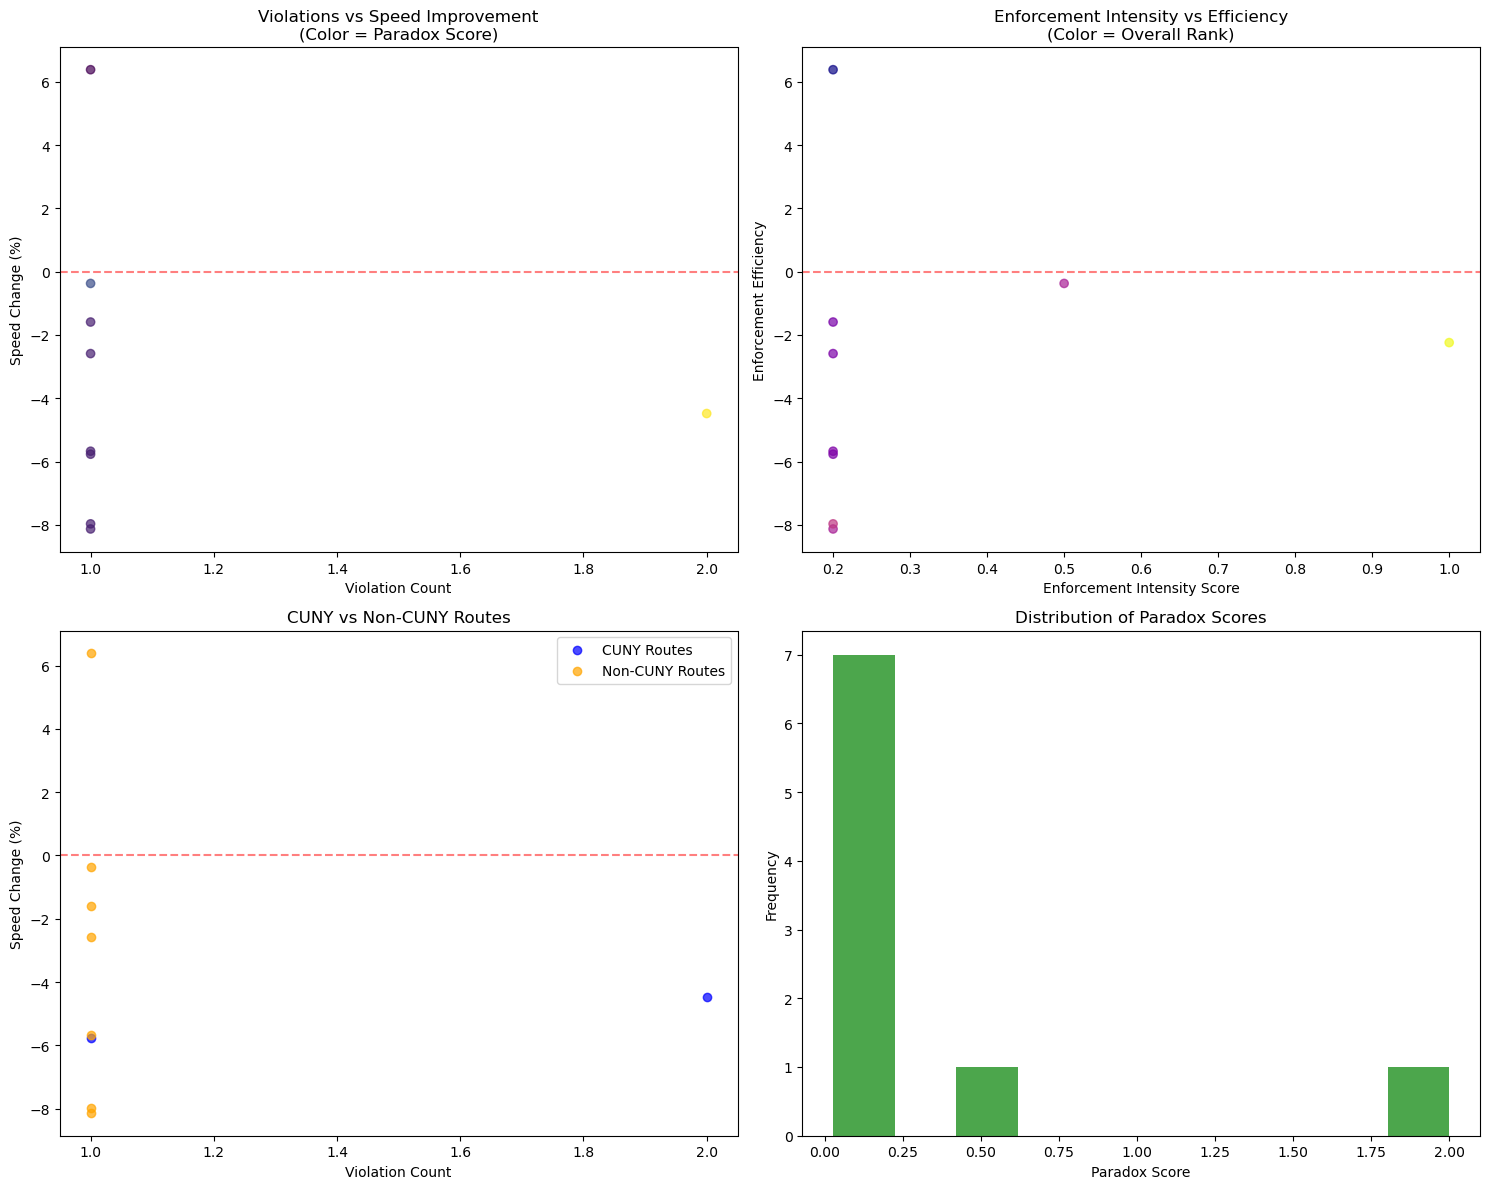

Visualization Insights:
- Red dashed line shows zero speed improvement
- Routes above the line: speed improved after ACE
- Routes below the line: speed got worse after ACE
- Higher paradox scores indicate enforcement isn't working effectively


In [32]:
# creating visualizations to understand the paradox
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# plot 1: violations vs speed improvement
axes[0, 0].scatter(master_sample['violation_count'], master_sample['speed_change_pct'], 
                   c=master_sample['paradox_score'], cmap='viridis', alpha=0.7)
axes[0, 0].set_xlabel('Violation Count')
axes[0, 0].set_ylabel('Speed Change (%)')
axes[0, 0].set_title('Violations vs Speed Improvement\n(Color = Paradox Score)')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# plot 2: enforcement intensity vs efficiency
axes[0, 1].scatter(master_sample['enforcement_intensity_score'], master_sample['enforcement_efficiency'],
                   c=master_sample['overall_paradox_rank'], cmap='plasma', alpha=0.7)
axes[0, 1].set_xlabel('Enforcement Intensity Score')
axes[0, 1].set_ylabel('Enforcement Efficiency')
axes[0, 1].set_title('Enforcement Intensity vs Efficiency\n(Color = Overall Rank)')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# plot 3: CUNY vs non-CUNY routes
cuny_data = master_sample[master_sample['serves_cuny'] == True]
non_cuny_data = master_sample[master_sample['serves_cuny'] == False]

axes[1, 0].scatter(cuny_data['violation_count'], cuny_data['speed_change_pct'], 
                   label='CUNY Routes', alpha=0.7, color='blue')
axes[1, 0].scatter(non_cuny_data['violation_count'], non_cuny_data['speed_change_pct'], 
                   label='Non-CUNY Routes', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Violation Count')
axes[1, 0].set_ylabel('Speed Change (%)')
axes[1, 0].set_title('CUNY vs Non-CUNY Routes')
axes[1, 0].legend()
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# plot 4: paradox score distribution
axes[1, 1].hist(master_sample['paradox_score'], bins=10, alpha=0.7, color='green')
axes[1, 1].set_xlabel('Paradox Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Paradox Scores')

plt.tight_layout()
plt.show()

print("Visualization Insights:")
print("- Red dashed line shows zero speed improvement")
print("- Routes above the line: speed improved after ACE")
print("- Routes below the line: speed got worse after ACE")
print("- Higher paradox scores indicate enforcement isn't working effectively")


## Key Insights and Takeaways

Let's summarize what we've learned about the ACE Intelligence Pipeline and its key metrics.


In [33]:
# summarizing key insights from our analysis
print("KEY INSIGHTS FROM THE ACE INTELLIGENCE PIPELINE")
print("=" * 60)

print("\n1. PARADOX SCORE EXPLAINED:")
print("   • Formula: (violation_count × enforcement_intensity) / speed_improvement_factor")
print("   • HIGH score = Lots of violations but NO speed improvement")
print("   • LOW score = Violations lead to speed improvements")
print("   • Purpose: Identifies where enforcement isn't working effectively")

print("\n2. ENFORCEMENT INTENSITY METRIC:")
print("   • Formula: (violations × 0.4 + ticketed × 0.6) / (vehicles + 1)")
print("   • Measures how 'concentrated' enforcement is")
print("   • Higher intensity = More violations per vehicle")
print("   • Purpose: Normalizes enforcement across different route sizes")

print("\n3. CUNY PROXIMITY ANALYSIS:")
print("   • Uses 500-meter buffer zones around CUNY campuses")
print("   • Calculates distances using Haversine formula")
print("   • Identifies routes serving educational institutions")
print("   • Purpose: Ensures student transportation gets proper attention")

print("\n4. THE ENFORCEMENT PARADOX:")
print("   • Routes with HIGH violations but LOW speed improvement")
print("   • Indicates enforcement resources may be misallocated")
print("   • Helps MTA optimize where to focus enforcement efforts")
print("   • Identifies routes needing different enforcement strategies")

print("\n5. DATA FLOW ARCHITECTURE:")
print("   • Phase 1A: Process violations → enforcement metrics")
print("   • Phase 1B: Aggregate speeds → speed changes")
print("   • Phase 1C: Calculate CUNY proximity → route mappings")
print("   • Phase 2: Combine all data → master dataset")
print("   • Phase 3: Calculate paradox scores → route rankings")

print("\nWHY THIS MATTERS:")
print("   • Helps MTA understand enforcement effectiveness")
print("   • Identifies routes where enforcement isn't working")
print("   • Makes sure student transportation gets proper attention")
print("   • Optimizes resource allocation for better bus performance")
print("   • Provides data-driven insights for policy decisions")


KEY INSIGHTS FROM THE ACE INTELLIGENCE PIPELINE

1. PARADOX SCORE EXPLAINED:
   • Formula: (violation_count × enforcement_intensity) / speed_improvement_factor
   • HIGH score = Lots of violations but NO speed improvement
   • LOW score = Violations lead to speed improvements
   • Purpose: Identifies where enforcement isn't working effectively

2. ENFORCEMENT INTENSITY METRIC:
   • Formula: (violations × 0.4 + ticketed × 0.6) / (vehicles + 1)
   • Measures how 'concentrated' enforcement is
   • Higher intensity = More violations per vehicle
   • Purpose: Normalizes enforcement across different route sizes

3. CUNY PROXIMITY ANALYSIS:
   • Uses 500-meter buffer zones around CUNY campuses
   • Calculates distances using Haversine formula
   • Identifies routes serving educational institutions
   • Purpose: Ensures student transportation gets proper attention

4. THE ENFORCEMENT PARADOX:
   • Routes with HIGH violations but LOW speed improvement
   • Indicates enforcement resources may be

## Next Steps

So this notebook basically proves our core idea works. The 'paradox score' isn't just a theory, we have a clear, data-driven way to calculate it on the real datasets.

The key thing to remember is that this was all done on a tiny sample of the data just to show the steps. The real patterns and insights will only show up when we run this pipeline on the full violation, speed, and ridership data.

My next step is to do exactly that and then use those rich features to build our predictive model. The goal is to forecast violation counts for specific bus stops and times. Such an approach is how we move from just analyzing the past to building the adaptive system that can give the mta actual recommendations for the next two days.
